In [1]:
%%javascript
IPython.notebook.get_cells().map( function(c) {  return c.code_mirror.options.cursorBlinkRate=0;  } );
CodeMirror.defaults.cursorBlinkRate=0;

<IPython.core.display.Javascript object>

In [2]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"
plt.rcParams["figure.facecolor"] = "White"
plt.rcParams["font.size"] = 8

# Using pyhepmc

Looking into jet events generated with pythia:

* Read hepmc2 ascii file
* Jet clustering
* Plotting of particles and jets for a few events, select events where there is a jet within the acceptance

In [3]:
import pyhepmc
#from pyhepmc.view import savefig

# in_file_name = "/home/pat/physics/scd/pythia8306/examples/pythia8_darkJets_test_mZp0p2_1k.hmc"
# in_file_name = "/home/pat/physics/scd/pythia8306/examples/pythia8_tautau_ptBias_1k.hmc"
#in_file_name = "/home/pat/physics/scd/pythia8306/examples/pythia8_dijets_partonPtMin100_5_mg5Input_rndSeed2.hmc"
in_file_name = "/srv01/agrp/annai/annai/QURK-GLUON/samples_produce/Pythia_Zqjets/pythia8_Zqjets_Seed10.hepmc"

in_file = pyhepmc.open(
    #"/home/pat/physics/scd/pythia8306/examples/pythia8_darkJets_test_1k.hmc"
    in_file_name
)
event = in_file.read()
event = in_file.read()
event = in_file.read()
#savefig(event, "event.eps")
event

In [4]:
def get_pt_rapidity_phi(event):
    particles = event.particles
    final_state_indices = np.where( [ p.status == 1 for p in particles ] )[0]
    px_all = np.array( [ particles[i].momentum.px for i in final_state_indices ] )
    py_all = np.array( [ particles[i].momentum.py for i in final_state_indices ] )
    pz_all = np.array( [ particles[i].momentum.pz for i in final_state_indices ] )
    e_all  = np.array( [ particles[i].momentum.e  for i in final_state_indices ] )
    pt = np.sqrt(
        px_all**2 + py_all**2
    )
    phi = np.arctan2(py_all, px_all)
    rapidity = 0.5 * np.log(
        (e_all + pz_all)
        / (e_all - pz_all)
    )
    return pt, rapidity, phi

## Select and plot events where there are jets within the acceptance 

In [13]:
from dijets import jet_selection
from dijets.event_selection import select_events

event_mask = select_events(
    in_file_name,
    10.0,
    3.0,
    0.4,
    10,
)
event_mask

[False]

In [10]:
import pyhepmc
# from pyhepmc.view import savefig
from dijets.jet_selection import get_jets, get_jets_eta
from dijets.event_selection import select_events

pt_jet_min_gev = 10.0
eta_abs_jet_max = 3.0
dR_jets_akt = 0.4
n_max_events_print = 4

in_file = pyhepmc.open(
    in_file_name
)
# event_mask = select_events( "/home/pat/physics/scd/pythia8306/examples/pythia8_dijets_partonPtMin100_100k.hmc",
#                            "dijet_partonPtMin100_100k_selection.hmc",
#                            pt_jet_min_gev,
#                            eta_abs_jet_max,
#                            dR_jets_akt )

n_max_events = 4
#in_file = pyhepmc.open("dijet_partonPtMin100_100k_selection.hmc")

jets_all_n = np.array([])
jets_all_pt = np.array([])
jets_all_eta = np.array([])
jets_all_phi = np.array([])

n_events_print = 1
n_events_select = 0
n_offset = 5

for i_event, event in enumerate(in_file):
    if i_event < n_offset:
        continue
    if n_events_select == n_max_events:
        break
    if i_event % 1 == 0:
        print("Analysing event {}".format(i_event))
    if not event_mask[i_event]:
        continue
    n_events_select += 1

    jets = get_jets(event, pt_jet_min_gev, eta_abs_jet_max, dR_jets_akt)
    if not len(jets):
        continue
    jets_pt = np.sqrt(jets.px**2 + jets.py**2)
    jets_eta = get_jets_eta(jets)
    jets_phi = np.arctan2(jets.py, jets.px)

    leading_jet_only = True
    if leading_jet_only:
        
        i_lead_jet = np.argmax(jets_pt)
    
        #  jets_all_pt  = np.append( jets_all_pt, np.sort( jets_pt )[::-1][:2] )
        jets_all_n = np.append(jets_all_n, len(jets))
        jets_all_pt = np.append(jets_all_pt, jets_pt[i_lead_jet])
        jets_all_eta = np.append(jets_all_eta, jets_eta[i_lead_jet])
        jets_all_phi = np.append(jets_all_phi, jets_phi[i_lead_jet])

    else:
        jets_all_n = np.append(jets_all_n, len(jets))
        jets_all_pt = np.append(jets_all_pt, jets_pt)
        jets_all_eta = np.append(jets_all_eta, jets_eta)
        jets_all_phi = np.append(jets_all_phi, jets_phi)
    
    if n_events_print < n_max_events_print:

        ax = plt.subplot(n_max_events_print // 2 + int(n_max_events_print % 2 != 0), 2, n_events_print + 1)
        ax.set(xlabel="rapidity", ylabel=r"$\varphi$")
        ax.set_xlim(-eta_abs_jet_max, eta_abs_jet_max)
        pt, rapidity, phi = get_pt_rapidity_phi(event)
        plt.scatter(rapidity, phi, s=pt * 0.1)

        for i_jet in range(len(jets)):
            jet_circle = plt.Circle(
                (jets_eta[i_jet], jets_phi[i_jet]), dR_jets_akt, color="r", fill=False
            )
            ax.add_patch(jet_circle)
            plt.text(
                jets_eta[i_jet] + dR_jets_akt + 0.1,
                jets_phi[i_jet] - 0.25 * dR_jets_akt,
                "{0:.0f}".format(jets_pt[i_jet]),
                fontsize=10,
                color="r",
            )
        n_events_print += 1

plt.tight_layout()
plt.savefig("dijets_eta_phi.png")
plt.show()

<Figure size 720x576 with 0 Axes>

/srv01/agrp/annai/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/srv01/agrp/annai/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/srv01/agrp/annai/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/srv01/agrp/annai/.local/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv01/agrp/annai/.local/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/srv01/agrp/annai/.local/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encounter

nan
nan


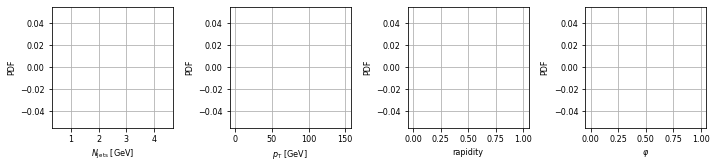

In [11]:
fig, axs = plt.subplots(1, 4, subplot_kw=dict(box_aspect=1))

ax = plt.subplot(1, 4, 1)
ax.hist(jets_all_n, histtype="step", density=True, bins=np.arange(0.5, 5.5, 1))
ax.set(xlabel=r"$N_{\mathrm{Jets}}$ [GeV]", ylabel="PDF")
ax.grid(True)
print(np.mean(jets_all_n))
print(np.std(jets_all_n))

ax = plt.subplot(1, 4, 2)
ax.hist(
    jets_all_pt * 1e-3, histtype="step", density=True, bins=np.linspace(0.0, 150.0, 20)
)
ax.set(xlabel=r"$p_{\mathrm{T}}$ [GeV]", ylabel="PDF")
ax.grid(True)

ax = plt.subplot(1, 4, 3)
ax.hist(jets_all_eta, histtype="step", density=True)
ax.set(xlabel="rapidity", ylabel="PDF")
ax.grid(True)

ax = plt.subplot(1, 4, 4)
ax.hist(jets_all_phi, histtype="step", density=True)
ax.set(xlabel=r"$\varphi$", ylabel="PDF")
ax.grid(True)

plt.tight_layout()
plt.savefig("dijets_pt_eta_phi_1d.png")
plt.show()